# Monte Carlo Simulations and Risk Analysis in Economic Valuation of Energy Investments
by Arturo Regalado <br>
Twitter: @arturoregalado <br>
LinkedIn: https://www.linkedin.com/in/arturo-regalado-3b672b34/ <br>
***

## Introduction

Projects in the energy industry are capital intensive. Because of their size the need to establish their profitability, it is necessary to do an economic valuation of such investments to support firms in deciding whether to invest or not in energy projects. 

The most common approach for the economic valuation of projects in the energy industry is capital budgeting thorugh Discounted Cash Flow Analysis (DCF). There is one shortcoming of DCF analysis: it assumes that the behaviour of the variables involved is fixed. However, energy projects face several sources of uncertainty, meaning some variables exhibit a random behaviour. In other words, energy projects are risky.  

Consequently, Risk Analysis also needs to be done to better assess the value of energy projects. Monte Carlo simulations (MC) is a useful method to model the probability of different outcomes due to the intervention of random variables. In other words, MC can enhance DCF by accounting for uncertainty in the variables that are part of the energy investment. 

### Objective of this notebook

In this notebook I show how to do Risk Analysis and Economic Valuation to assess the profitability of an investment in energy generation capacity using the programming language Python. Two broad objectives are achieved with the notebook:

1. Showcase the essence of economic valuation in energy investments using DCF and MC analyses.  
2. Create a python tutorial for doing basic Discounted Cash Flow analysis and Monte Carlo simulations. 

**Disclaimer:** by no means this notebook shows an exhaustive treatment of capital budgeting techniques and risk analysis. It only strives to showcase the basic notions required to undertake economic valuation initiatives and presents a practical tutorial on how to use Python for such purposes. The data and business settings are entirely made up; the models are highly simplified. A thorough exposition of DCF or MC methods is not the scope of this notebook. I will deal only with the practical side of undertaking it and using assumptions that may not be the best for the problem at hand.

** The python coding I present is not the only way to do this analysis. I encourage you to try different ways. That is the beauty of data analysis and coding. <br> 
***

## Business setting

Windy Enterprises Limited is looking to expand its renewables electricity generation portfolio in Scotland. As an energy economist you have been asked to assess the profitability of investing in an onshore wind farm of 6 energy turbines. The finance and engineering departments from Windy came up with the following assumptions:

+ Wholesale electricity price in £/MWh: 50
+ Capital costs per turbine in million £: .8
+ Marginal costs per turbine (operating and maintenance) in £: 50,000
+ Project WACC in %: 10 
+ Load factor of each turbine in %: 35
+ Potential operation hours per turbine: 8760
+ Turbine set up time: 2 year
+ Turbine lifetime: 20 years 

<font color=blue>Should Windy invest in the onshore wind farm?</font>

### Strategy to solve the problem

To solve this problem I propose the following steps:

1. Undertake a Discounted Cash Flow analysis and estimate the Net Present Value of the project.
2. Account for uncertainty in key variables using Monte Carlo Simulations.
3. Present the results and recommend an investment decision.
***

## Discounted Cash Flow Analysis
The first step in the economic valuation of the wind farm investment is to undertake a Discounted Cash Flow Analysis. The objective is to calculate the Net Present Value (NPV) of the project. This measure is, possibly, the most important decision tool in when doing capital budgeting on an investment. The NPV is the resulting difference between the revenues and costs in present value. If the NPV is positive the firm should invest because the benefits outweigh  the costs; if it is negative the firm should not invest because the costs outweigh the benefits.

The formula for NPV

$$ NPV = \sum_{t=0}^{T} \frac{R - C}{(1+r)^t} $$

Where: 

$R = $ revenues <br>
$C = $ total costs <br>
$r = $ discount factor (normally the cost of capital) <br>
$I = $ capital investments <br>
$t = $ year or time period <br>

Because the purpose of this notebook is to showcase a basic DCF, I will assume there is no inflation, depreciation allowance, tax scheme and decommissioning. 

**Now for the fun part, lets compute the NPV using Python**

In [1]:
#Import libraries that will be used

import pandas as pd             # For data manipulation
import numpy as np              # For working with multidimensional arrays
import matplotlib.pyplot as plt # Base program for plotting
import seaborn as sns           # Package with more stylized plotting capaibilites 
from textwrap import wrap       # To assist in wraping text of figures

# Set styles for plots
sns.set_style('dark')

%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [25]:
# Set base assumptions
electricity_price = 50
capex = .8
capex_millions_factor = 1000000
opex = 50000
wacc = .10 
load_factor = .35
operational_hours = 8760
turbine_number = 6
turbine_lifetime = 20 
construction_schedule = [0,1] # Project years where construction takes place 
project_lifetime = len(construction_schedule) + turbine_lifetime


In [26]:
# Set time range for the project
# Year zero is when the project begins, also remember python index begins at 0
project_life = np.arange(start = 0, stop = project_lifetime)

# Set construction schedule - % of capital costs expenditures of 
# the turbines is built each year
construction_status = []
for year in project_life:
    if year <= np.max(construction_schedule):
        construction_status.append(.5)  # .5 = 50% capital costs
    else:
        construction_status.append(0)  # 0 = not incurring capital costs


# Set operational status of the turbines
operation_status = []
for year in project_life:
    if year <= np.max(construction_schedule):
        operation_status.append(0)  # 0 = not operational
    else:
        operation_status.append(1)  # 1 = operational



# Build base Dataframe to store the results and simplify
# calculations with Pandas vectorization capabilities

df = pd.DataFrame(data = {
    'con_status': construction_status,
    'op_status': operation_status,
    'project_year': project_life
})

print('Check if data frame was set up correctly:')
print('--------------Head-----------------------')
print(df.head())
print('--------------Tail-----------------------')
print(df.tail())

Check if data frame was set up correctly:
--------------Head-----------------------
   con_status  op_status  project_year
0         0.5          0             0
1         0.5          0             1
2         0.0          1             2
3         0.0          1             3
4         0.0          1             4
--------------Tail-----------------------
    con_status  op_status  project_year
17         0.0          1            17
18         0.0          1            18
19         0.0          1            19
20         0.0          1            20
21         0.0          1            21


It is worth noting that putting the data in a pandas data frame is helpful to ease calculations and have spreadsheet style views. This is important because for most professionals are acquainted with spreadsheets than code results.

### Computing profits, revenues and costs

Now that the base data frame and assumptions are set it is possible to build the DCF model to calculate the NPV. The resulting data frame after all calculations are applied will be the cash flow schedule for the project.

#### Revenues

Considerations:

+ Revenues are only obtained in the operational years of the turbines.
+ The general formula for revenues is price * quantity produced.
+ For this example, quantity produced is MWh of electricity for the number of turbines. Consequently:

$$ MWh \: produced = Number \: of \: turbines * Operational \: hours * Load \: factor$$

#### Costs

Considerations:

+ Capex costs are incurred only when setting up the turbines, opex are incurred on operational years
+ The general formula for total costs is (variable costs * quantity )+ fixed costs
+ For this example variable costs are opex, quantity is the number of turbines, and fixed costs (capex) will be treated only as the initial investment (I in the NPV equation)

Consequently:

$$ Total \: costs = (Number \: of \: turbines * opex) + capex $$

In [27]:
# Revenues

## Make the formula and multiply by the operation status to get
## the yearly electricity production and plug to the data frame
df['electricity_output'] = turbine_number * operational_hours * load_factor * df.op_status
df['revenues'] = df.electricity_output * electricity_price

# Costs

## Capital investment costs
df['capital_costs'] = turbine_number * (capex*capex_millions_factor) * df.con_status

## Make the formula and multiply by the operation status to get
## the yearly variable costs to the data frame
df['variable_costs'] = turbine_number * opex * df.op_status

## Total costs
df['total_costs'] = df['variable_costs'] +  df['capital_costs']

# Calculate the profits, the difference between revenues and total costs
# Equivalent to the numerator in the NPV formula
df['profits'] = df['revenues'] -  df['total_costs']

# If you come from heay excel use, you may choose to display 
# the cash flow streams horizontally
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
con_status,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
op_status,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
project_year,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
electricity_output,0.0,0.0,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0,...,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0,18396.0
revenues,0.0,0.0,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0,...,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0,919800.0
capital_costs,2400000.0,2400000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
variable_costs,0.0,0.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,...,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
total_costs,2400000.0,2400000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,...,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
profits,-2400000.0,-2400000.0,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0,...,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0,619800.0


***
## Computing NPV

To obtain the NPV, a metric that reflects the value of the project, it is only a matter of discounting and applying the formula to the information in the cashflow schedule. The weighted average cost of capital is commonly used as the discounting factor when doing capital budgeting. 


In [28]:
# Discount the profits (balance of the cashflows) to put
# them in present value terms. Then sum to get the NPV

## Make a function to reuse

def calculate_NPV(cashflow_dataframe, profits, project_years, discount_factor):
    '''
    cashflow_dataframe: a pandas dataframe with all the cashflow strams
    prints: string with the name of the colum that contains the profits
    project_years: string with the name of the column that has the project year
    discount_factor: value of the cost of capital
    '''
    
    NPV_df = pd.DataFrame({
    'proftis': np.array(cashflow_dataframe[profits]),
    'time': np.array(df[project_years])
    })
    
    
    NPV_df['PV'] = NPV_df['proftis'] / (1+discount_factor)**NPV_df['time']
    NPV = NPV_df['PV'].sum()
    return NPV

# Calculate NPV and recommended decision
result = calculate_NPV(df, 'profits', 'project_year', wacc)

print("The Net Present Value of the project is: £{0:,.2f}".format(result))
if result > 0:
    print('Recommended investment decision: invest')
elif result < 0:
    print('Recommended investment decision: not invest')
else:
    print('Recommended investment decision: indifferent (NPV = 0)')

        

The Net Present Value of the project is: £215,187.99
Recommended investment decision: invest


The positive NPV means that the wind farm will give value to Windy Enterprises. Looking only at the DCF model I would advise the company to invest. However, DCF is a deterministic model and as I noted in the introduction energy investments are uncertain. To account for the uncertainty in the project, Risk Analysis needs to be done. Therefore, the next section shows how to do Monte Carlo Simulatios to determine how will NPV be affected by random behaviour of certain variables. 

***
## Risk Analysis using Monte Carlo Simulations

Because risk is part of energy investments, when doing economic valuation, it is necessary to use a method that accounts for it in order to have a more informed investment decision. Monte Caro Simulations (MC) is a method that is commonly applied for these purposes. 

There are two basic steps that need to be followed when doing MC analysis:

1. Define a model and metric of interest.
2. Define the variables that are thought random, simulate random values and apply to the model of interest.
3. Apply simulated values to the model and get: probability distribution of NPV, histograms, average value, and confidence intervals.

### Defining a model and metric of interest

To inform an investment decision, the firm is interested in how is the NPV affected by the random behaviour of some variables that are part of its calculations. Therefore, the model of interest is the DCF and the metric is the NPV. 
***

### Define the random variables and simulate values

In this notebook I will explore uncertainty on two variables: electricity prices and load factor.

+ Modelling uncertainty on prices makes a lot of sense. Electricity price is a key variable that has the potential to make or break an investment; cash flows are heavily dependent on price. Additionally, in competitive markets, prices are not fixed and constantly change. 

+ The load factor affects the quantity of electricity produced. In the case of wind farms, production depends on weather conditions which are random. 

### Simulating the random variables

Perhaps the most important issues in MC is defining the probability distribution and finding the parameters of the random variables to be modelled. Two approaches can be used:

1. Draw a sample of the random variable, fit different distributions and apply a statistical test such as the Kolmogorov-Smirnov test to find the best fit.
2. Define a probability distribution and parameters based on domain subject expertise (more a subjective than objective approach).

Let's define the probability distribution of the random variables and simulate some values. For the case of electricity prices, I will fit a lognormal distribution to a sample of the UK's wholesale electricity prices and find the parameters that describe their distribution. The lognormal distribution has been found to describe price series in financial settings and has the appealing feature that values cannot be negative (prices cannot be negative).  

I downloaded the United Kingdom's 1 day ahead monthly average electricity wholesale price from OFGEM from June 2010 to December 2018. The data is available from this link https://www.ofgem.gov.uk/data-portal/all-charts/policy-area/electricity-wholesale-markets. 

For the load factor I will assume a uniform distribution that can take values from 25% to 45%. Bear with me on this range. Scotland is known for having changing weather and its behaviour could be thought as random. All values can occur with the same probability. Therefore, lets assume this range and distribution is true. 

Descriptive statistics of wholesale
electricity price in the UK
-----------------------------------
            Price
count  103.000000
mean    46.693398
std      7.368920
min     33.850000
25%     41.880000
50%     46.400000
75%     50.775000
max     67.690000


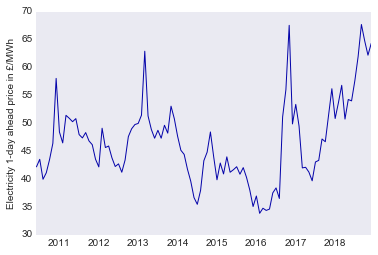

In [29]:
# Load electricity price data
# Show descriptive statistics and plot
df_prices = pd.read_csv('electricity_prices.csv')
df_prices['Date'] = pd.to_datetime(df_prices['Date'], format= "%d/%m/%Y")
df_prices = df_prices.set_index('Date')
df_prices.plot(color = sns.xkcd_rgb["royal blue"], legend = False)
plt.ylabel('Electricity 1-day ahead price in £/MWh')
plt.xlabel('')

print("Descriptive statistics of wholesale")
print("electricity price in the UK")
print("-----------------------------------")
print(df_prices.describe())



We see from the above results that the average price in the sample is 46.70 pounds per MWh and that there is some price volatility. The next step is to fit a lognormal distribution and simulate values from the obtained parameters, as well as simulating the load factor values. 

In this exercise I will do a MC analysis with 5,000 trials, i.e. simulating 5000 values of electricity price and load factor.  

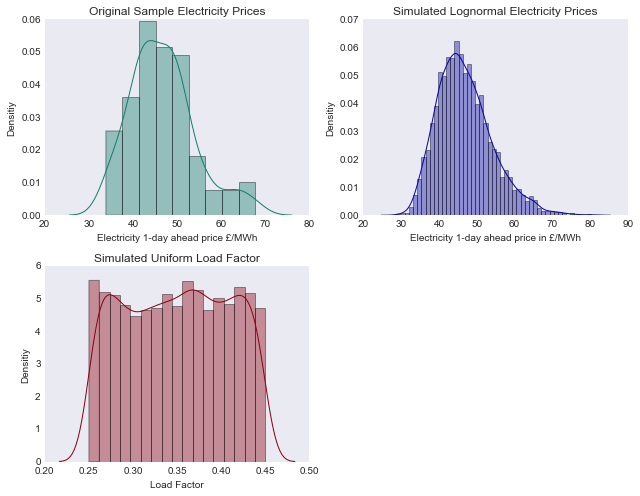

In [30]:
from scipy import stats # Package to work with the probability distributions and fit

# Fit lognormal to price sample to find parameters and simulate n values
n = 5000 # number of trials
randomseed = 1234 # seed for reproducibility
np.random.seed(randomseed)

log_shape, log_loc, log_scale = stats.lognorm.fit(df_prices["Price"]) # Fit distribution to sample
sim_prices = stats.lognorm.rvs(s = log_shape, loc = log_loc, scale = log_scale, size = n, random_state = randomseed) # Simulate prices

# Draw random sample from Uniform Distribution
# a = lower bound, b = upper bound
a = .25
b = .45
sim_loadfactor = np.random.uniform(a,b,n)

# Plot sample and simulated prices to evaluate fit of distribution
# Plot distribution of the simulated loadfactor
plt.subplots(figsize = (9,7))
plt.subplot(221)
sns.distplot(df_prices['Price'], color = sns.xkcd_rgb["blue green"])
plt.xlabel('Electricity 1-day ahead price £/MWh')
plt.ylabel('Densitiy')
plt.title('Original Sample Electricity Prices')

plt.subplot(222)
sns.distplot(sim_prices, color = sns.xkcd_rgb["royal blue"])
plt.xlabel('Electricity 1-day ahead price in £/MWh')
plt.ylabel('Densitiy')
plt.title('Simulated Lognormal Electricity Prices')

plt.subplot(223)
sns.distplot(sim_loadfactor, color = sns.xkcd_rgb["crimson"])
plt.xlabel('Load Factor')
plt.ylabel('Densitiy')
plt.title('Simulated Uniform Load Factor')

plt.tight_layout()

From the above plots it can be seen that the original and simulated prices have a very similar distribution. Additionally, the load factor has a nicely behaved uniform distribution within the bounds. Now all that remains is using the simulated price and load factor to the model the riksy cash flows and compute the NPV.
***
## Using the simulated random variables in the DCF and estimate NPV

In [31]:
# Calculate NPV using the simulated random variables

## Zip the simulated prices for looping when applying to the model
## Zip assigns two values in a list as ordered pairs
random_variables = list(zip(sim_prices, sim_loadfactor))


## Substitute random variables in the deterministic DCF model
## store simulated NPV for each combination of the random variables
sim_NPV = []
for sim_price, sim_load in random_variables:
    
    # Set time range for the project project
    # Year zero is when the project begins, also remember python index begins at 0
    project_life = np.arange(start = 0, stop = project_lifetime)

    # Set construction schedule -capital costs expenditures of the turbines (what % each year)- 
    construction_status = []
    for year in project_life:
        if year <= np.max(construction_schedule):
            construction_status.append(.5)  # .5 = 50% capital costs
        else:
            construction_status.append(0)  # 0 = not incurring capital costs
        
    # Set operational status of the turbines
    operation_status = []
    for year in project_life:
        if year <= np.max(construction_schedule):
            operation_status.append(0)  # 0 = not operational
        else:
            operation_status.append(1)  # 1 = operational

    # Build base Dataframe to store the results and simplify calculations with Pandas vectorization capabilities
    df = pd.DataFrame(data = {
        'project_year': project_life,
        'op_status': operation_status,
        'con_status': construction_status
    })

    # Revenues
    df['electricity_output'] = turbine_number * operational_hours * sim_load * df.op_status
    df['revenues'] = df.electricity_output * sim_price


    # Costs
    df['capital_costs'] = turbine_number * (capex*capex_millions_factor) * df.con_status
    df['variable_costs'] = turbine_number * opex * df.op_status
    df['total_costs'] = df['variable_costs'] +  df['capital_costs']

    # Calculate the profits, the difference between revenues and total costs
    # That is the numerator in the NPV formula
    df['profits'] = df['revenues'] -  df['total_costs']
         
    
    result = calculate_NPV(df, 'profits', 'project_year', wacc)
    sim_NPV.append(result)


In [32]:
# Make a data frame from the Monte Carlo results for further processing
MC_df = pd.DataFrame({'sim_prices': sim_prices,
                      'sim_costs': sim_loadfactor,
                      'sim_NPV': sim_NPV})

print('Descriptive statistics of the simulated random variables and NPV:')
print('-------------------------------------------------------')
MC_df.describe()

Descriptive statistics of the simulated random variables and NPV:
-------------------------------------------------------


,sim_NPV,sim_costs,sim_prices
count,5.000000e+03,5000.000000,5000.000000
mean,-2.309212e+05,0.349830,46.852727
std,1.551033e+06,0.058135,7.302589
min,-3.573084e+06,0.250005,28.770584
25%,-1.404379e+06,0.298455,41.601161
50%,-3.624853e+05,0.351284,45.942682
75%,7.484206e+05,0.400432,51.077017
max,6.448533e+06,0.449993,81.277155


----------------------------------------
Risk Analysis results
----------------------------------------
Average NPV: £-230,921.24
Stanard Deviation of NPV: £1,551,032.60
Maximum NPV: £6,448,532.93
Minimium NPV: £-3,573,083.99
Probability of negative NPV:58.84%
95% Confidence Interval:
From £-273,913.67 to £-187,928.81
----------------------------------------


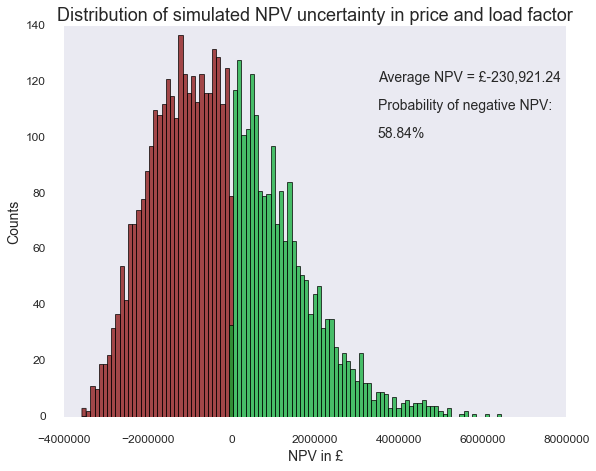

In [37]:
# Now compute results of interest and plots of distribution of values

# Desctiptive statistics of the simulated NPV
mean_NPV = MC_df['sim_NPV'].mean()
sd_NPV = MC_df['sim_NPV'].std()
max_npv = MC_df['sim_NPV'].max()
min_NPV = MC_df['sim_NPV'].min()


# Calculate probability of loss
NPV = np.array(MC_df['sim_NPV'])
negnpv = NPV[(NPV < 0)]
lossprob = np.round(len(negnpv) / len(NPV), 4) * 100


#Calculate 95% confidence interval
z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value at 5%*
margin_of_error = 1.96 * math.sqrt(sd_NPV**2/len(NPV))
confidence_interval = (mean_NPV - margin_of_error, mean_NPV + margin_of_error) 


print("----------------------------------------")
print("Risk Analysis results")
print("----------------------------------------")
print("Average NPV: £{0:,.2f}".format(mean_NPV))
print("Stanard Deviation of NPV: £{0:,.2f}".format(sd_NPV))
print("Maximum NPV: £{0:,.2f}".format(max_npv))
print("Minimium NPV: £{0:,.2f}".format(min_NPV))
print('Probability of negative NPV:' + str(lossprob) + '%')
print("95% Confidence Interval:")
print("From £{0:,.2f}".format(confidence_interval[0]) + " to £{0:,.2f}".format(confidence_interval[1]) )
print("----------------------------------------")



# Try histogram with two colors
# make equal binning through the range, you can adapt the bin size here
NPV = np.array(NPV)
counts, bins = np.histogram(NPV, bins=100)

# here we do the filtering and split the observations based on color code
x1 = NPV[(NPV < 0)]
x2 = NPV[(NPV >= 0)]

# finally, do the plot
f, ax = plt.subplots(figsize = (9,7))
ax.hist(x1, bins=bins, color = sns.xkcd_rgb["dark red"], alpha = 0.7)
ax.hist(x2, bins=bins, color = sns.xkcd_rgb["kelly green"], alpha = 0.7)
plt.xlabel('NPV in £', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title('Distribution of simulated NPV uncertainty in price and load factor', fontsize = 18)
plt.tick_params(labelsize=12, pad=6)


ax.text(3500000, 120, "Average NPV = £{0:,.2f}".format(mean_NPV), fontsize=14)
ax.text(3500000, 110, 'Probability of negative NPV:', fontsize=14)
ax.text(3500000, 100, str(np.round(lossprob,2)) + '%', fontsize=14)
sns.despine()

***
## Discussion of results and conclusion

Judging from the results of the DCF and MC analysis, Windy Enterprises Limited should not invest in the wind farm project in Scotland because of the high risk. The following results support the statement:

1. Even though in the deterministic model the NPV was positive, when accounting for uncertainty in electricity price and load factor, the average NPV was negative and the probability of losses is approximately 59%
2. If random NPVs were to be drawn, 95% of the times its value would be between approximately -280k and -200k pounds